In [3]:
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import numpy as np
import pandas as pd
import powerplantmatching as pm
import pypsa
import xarray as xr
#from _helpers import configure_logging, create_logger, read_csv_nafix, update_p_nom_max
from powerplantmatching.export import map_country_bus
import yaml
import geopandas as gpd

with open('../../../pypsa-earth/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [3]:
scenario_PyPSA = "SEA_BAU_"
network_name = "elec_s_200_ec_lcopt_3H"
folder_name = "pypsa-earth"

years = [2020,2025,2030,2035,2040,2045,2050]

fn_powerplants = {year:pd.read_csv(f"../{folder_name}/resources/{scenario_PyPSA}{year}/powerplants.csv") for year in years}

for year in years:
    date_out = fn_powerplants[year].DateOut.min()
    print(f"the date out for year {year} is {date_out}")
    date_in = fn_powerplants[year].DateIn.max()
    print(f"the date in for year {year} is {date_in}")

the date out for year 2020 is 2020.0
the date in for year 2020 is 2020.0
the date out for year 2025 is 2020.0
the date in for year 2025 is 2025.0
the date out for year 2030 is 2020.0
the date in for year 2030 is 2028.0
the date out for year 2035 is 2026.0
the date in for year 2035 is 2028.0
the date out for year 2040 is 2030.0
the date in for year 2040 is 2028.0
the date out for year 2045 is 2038.0
the date in for year 2045 is 2028.0
the date out for year 2050 is 2050.0
the date in for year 2050 is 2028.0


# Plot the amount of coal powerplants

In [4]:
scenario_PyPSA = "SEA_AIMS_"
network_name = "elec_s_200_ec_lcopt_3H"
folder_name = "pypsa-earth"

years = [2020,2025,2030,2035,2040,2045,2050]

fn_powerplants = {year:pd.read_csv(f"../../../{folder_name}/resources/{scenario_PyPSA}{year}/powerplants.csv") for year in years}

In [56]:
def plot_powerplants(fn_powerplants,years):
    
    carrier_color = {'Lignite':'#9e5a01',
                     'Hard Coal CFB':'#808080',
                     'Hard Coal ultra-supercritical':'#505050',
                     'Hard Coal supercritical':'#606060',
                     'Hard Coal subcritical':'#909090',
                     'Hard Coal':'#707070',
                    }
    
    df_p = pd.DataFrame(data={year:fn_powerplants[year].groupby("Fueltype").Capacity.sum() for year in years})
    df_p = df_p.loc[['Hard Coal','Hard Coal subcritical','Hard Coal supercritical','Hard Coal ultra-supercritical','Hard Coal CFB','Lignite']]/1e3
    
    fig, ax = plt.subplots(figsize=(7,3))
    
    df_p.T.plot.area(ax=ax,stacked=True, color=[carrier_color[carrier] for carrier in df_p.index], legend=False)

    
    ax.set_xlim([2020, 2050])
    ax.set_xlabel("year")
    ax.set_ylabel("GW")
    ax.grid()

    pypsa.plot.add_legend_patches(ax=ax, colors = list(carrier_color.values()), labels = list(carrier_color.keys()),
                                 legend_kw = {'loc':"upper center",'bbox_to_anchor':(0.5, -0.15), 'frameon':False, 'ncol':3, 'title':"Capacity", 
                                              'title_fontproperties':{'weight':'bold'}})

    plt.savefig("powerplant_capacity_year.svg",bbox_inches="tight")

    return df_p

def plot_powerplants_r(fn_powerplants,years):
    
    carrier_color = {'coal': '#707070',
                     'coal-SubC': '#909090',
                     'coal-SC': '#606060',
                     'coal-USC': '#505050',
                     'coal-CFB': '#808080',
                     'ccgt':'#b20101',
                     'geothermal':'#ba91b1',
                     'lignite':'#9e5a01',
                     'oil':'#262626'
                    }
    
    df_p = pd.DataFrame(data={year:fn_powerplants[year].groupby("carrier").p_nom.sum() for year in years})
    df_p = df_p.loc[['coal','lignite']]/1e3
    
    fig, ax = plt.subplots(figsize=(6,3))
    
    df_p.T.plot.area(ax=ax,stacked=True, color=[carrier_color[carrier] for carrier in df_p.index])
    df_p
    
    ax.set_xlim([2020, 2050])
    ax.set_xlabel("year")
    ax.set_ylabel("GW")
    ax.grid()

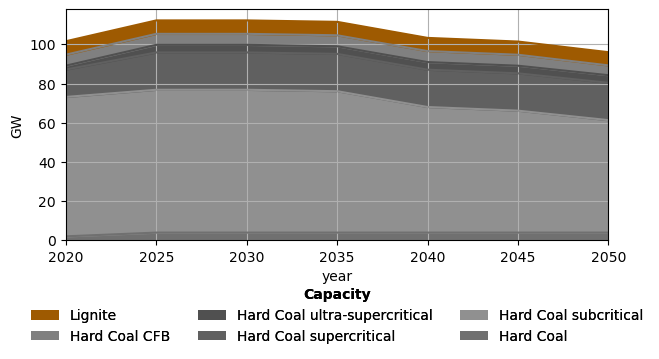

In [57]:
#years = [2020,2025]
df = plot_powerplants(fn_powerplants,years)

In [68]:
df2 = df.copy(deep=True)

for c in df2.columns:
    df2[c] = df[c]/df[c].sum()*100

df2.T.mean()

Fueltype
Hard Coal                         3.518670
Hard Coal subcritical            63.948205
Hard Coal supercritical          17.402031
Hard Coal ultra-supercritical     3.425451
Hard Coal CFB                     5.240498
Lignite                           6.465145
dtype: float64

In [69]:
df2.T.min()

Fueltype
Hard Coal                         2.047109
Hard Coal subcritical            59.758435
Hard Coal supercritical          13.764842
Hard Coal ultra-supercritical     1.950659
Hard Coal CFB                     4.992676
Lignite                           6.105139
dtype: float64

In [70]:
df2.T.max()

Fueltype
Hard Coal                         4.145305
Hard Coal subcritical            69.979514
Hard Coal supercritical          19.832891
Hard Coal ultra-supercritical     4.043235
Hard Coal CFB                     5.523231
Lignite                           7.009167
dtype: float64

In [7]:
len(fn_powerplants[2020].query("Fueltype in ['Hard Coal','Lignite']"))

25

In [8]:
len(fn_powerplants[2025].query("Fueltype in ['Hard Coal','Lignite']"))

28

In [9]:
#years = [2025,2030,2035,2040,2045]
#plot_powerplants_r(fn_powerplants_r,years)

# I have to do the filtering myself

In [32]:
ppl = fn_powerplants[2020]


carrier_color = {'Hard Coal':'#707070',
                 'Hard Coal CFB':'#808080',
                 'Hard Coal ultra-supercritical':'#505050',
                 'Hard Coal supercritical':'#606060',
                 'Hard Coal subcritical':'#909090',
                 'CCGT':'#b20101',
                 'Geothermal':'#ba91b1',
                 'Lignite':'#9e5a01',
                 'Oil':'#262626'
                }

fossil_fuel = list(carrier_color.keys())
fossil_fuel

ppl = ppl.query("Fueltype in @fossil_fuel")

df = pd.DataFrame(index=range(2000,int(ppl.DateOut.max())),columns=fossil_fuel)

for f in fossil_fuel:
    df[f] = [ppl.query("DateOut >= @y & Fueltype == @f").Capacity.sum() for y in df.index]

In [27]:

for c in fossil_fuel:
    rate = (df[c].max() - df[c].min()) / df[c].max()
    print(c + " : " + str(rate))

Hard Coal : 0.4230769230769231
Hard Coal subcritical : 0.9823919560449507
Hard Coal supercritical : 1.0
Hard Coal ultra-supercritical : 0.0
Hard Coal CFB : 0.9036258909797169
CCGT : 1.0
Geothermal : 1.0
Lignite : 0.8832399191788232
Oil : 1.0


In [31]:
for c in fossil_fuel:
    maxi = df[c].max()
    print(c + " : " + str(maxi))

Hard Coal : 2080.0
Hard Coal subcritical : 71103.86611915375
Hard Coal supercritical : 13986.0
Hard Coal ultra-supercritical : 1982.0
Hard Coal CFB : 5603.16464130787
CCGT : 97583.59266439246
Geothermal : 1294.4
Lignite : 6851.656785209279
Oil : 25278.345999617693


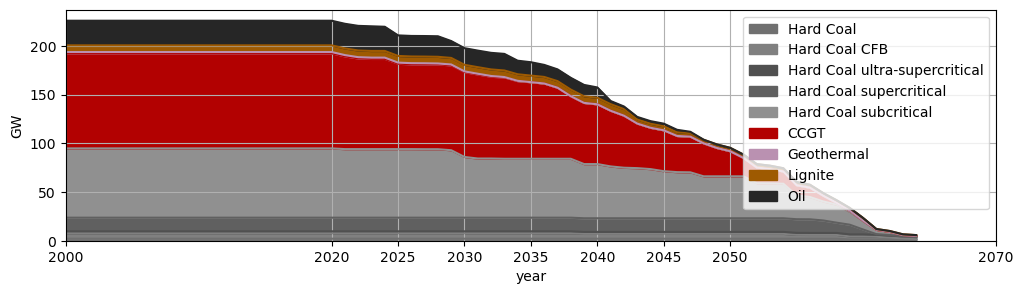

In [33]:
fig, ax = plt.subplots(figsize=(12,3))

df2 = df/1e3 

df2.plot.area(ax=ax,stacked=True, color=[carrier_color[carrier] for carrier in df.columns])

ax.set_xlim([2000, 2070])
ax.set_xlabel("year")
ax.set_ylabel("GW")
ax.set_xticks([2000,2020,2025,2030,2035,2040,2045,2050,2070])
ax.grid()

# Archive

In [11]:
ppl = pd.read_csv("../pypsa-earth-archive-July-2024/resources/SEA_base/powerplants.csv")

fossil_fuel = ['Hard Coal','CCGT','Geothermal','Lignite','Oil']
renewable = ['Hydro','Bioenergy','Waste']
ppl = ppl.query("Fueltype in @fossil_fuel")

df = pd.DataFrame(index=range(2000,int(ppl.DateOut.max())),columns=fossil_fuel)

for f in fossil_fuel:
    df[f] = [ppl.query("DateOut >= @y & Fueltype == @f").Capacity.sum() for y in df.index]

In [12]:
carrier_color = ['#707070','#b20101','#ba91b1','#9e5a01','#262626']

In [13]:
df2 = df/1e3 

In [26]:
df.loc[2020,"Hard Coal"] + df.loc[2020,"Lignite"]

133828.2875456709

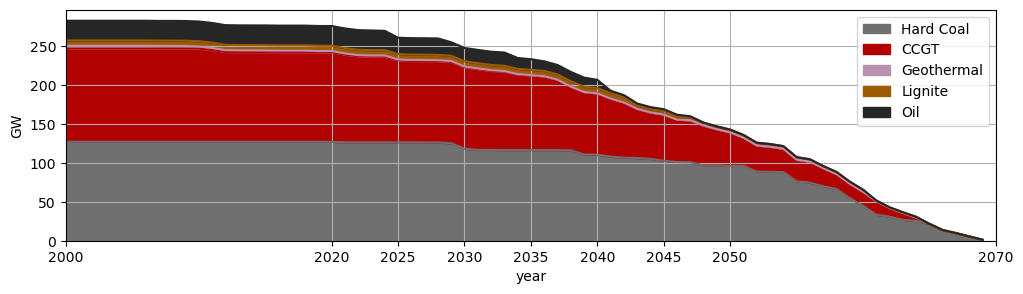

In [20]:
fig, ax = plt.subplots(figsize=(12,3))

df2.plot.area(ax=ax,stacked=True, color=carrier_color)

ax.set_xlim([2000, 2070])
ax.set_xlabel("year")
ax.set_ylabel("GW")
ax.set_xticks([2000,2020,2025,2030,2035,2040,2045,2050,2070])
ax.grid()

In [40]:
df = pd.DataFrame(index=range(2020,2071,5),columns=["Yearstep_BAU","Yearstep_PD10","Yearstep_PD20","Yearstep_PD30"])

df["Yearstep_BAU"] = df.index
df.loc[2060,"Yearstep_PD10"] = 2070
df.loc[2050,"Yearstep_PD20"] = 2070
df.loc[2040,"Yearstep_PD30"] = 2070

for ys in df.columns[df.columns != 'Yearstep_BAU']:
    df.loc[2020,ys] = 2020
    df[ys] = df[ys].infer_objects(copy=False).interpolate(method='linear')

df = df.replace(2070, np.NaN)
df.loc[2070,"Yearstep_BAU"] = 2070
df.loc[2060,"Yearstep_PD10"] = 2070
df.loc[2050,"Yearstep_PD20"] = 2070
df.loc[2040,"Yearstep_PD30"] = 2070

In [41]:
df.round(2)

,Yearstep_BAU,Yearstep_PD10,Yearstep_PD20,Yearstep_PD30
2020,2020.0,2020.00,2020.00,2020.0
2025,2025.0,2026.25,2028.33,2032.5
2030,2030.0,2032.50,2036.67,2045.0
2035,2035.0,2038.75,2045.00,2057.5
2040,2040.0,2045.00,2053.33,2070.0
2045,2045.0,2051.25,2061.67,NaN
2050,2050.0,2057.50,2070.00,NaN
2055,2055.0,2063.75,NaN,NaN
2060,2060.0,2070.00,NaN,NaN
2065,2065.0,NaN,NaN,NaN


# Where is the CCGT?

In [18]:
RDIR = "SEA_BAU_2050/"
country_shapes = gpd.read_file("../pypsa-earth/resources/" + RDIR + "shapes/country_shapes.geojson").set_index("name")

ppl_gdf = gpd.GeoDataFrame(ppl, geometry=gpd.points_from_xy(ppl.lon, ppl.lat), crs="EPSG:4326") 

<GeoAxesSubplot:>

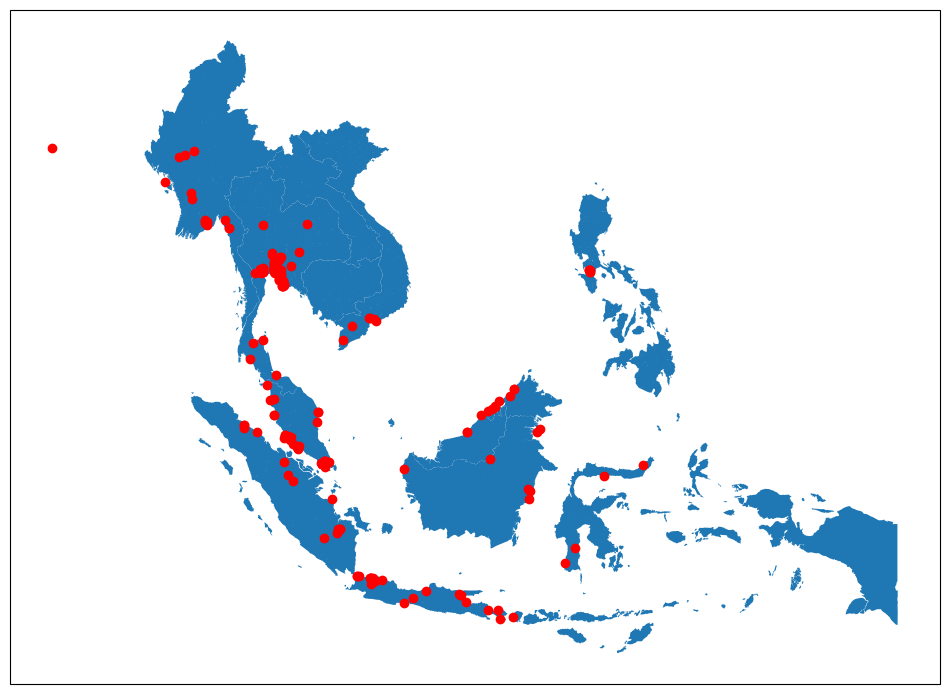

In [22]:
fig = plt.figure(figsize=(12,12))
crs = ccrs.PlateCarree()
ax = plt.axes(projection=crs)

country_shapes.plot(ax=ax)
ppl_gdf.query("Fueltype == 'CCGT'").plot(ax=ax,
            color="red")

In [23]:
ppl_gdf

,Unnamed: 0,Name,Fueltype,Technology,Set,Country,Capacity,Efficiency,Duration,Volume_Mm3,...,StorageCapacity_MWh,DateIn,DateRetrofit,DateOut,lat,lon,EIC,projectID,bus,geometry
0,0,Glow Energy Complex,Hard Coal,NaN,CHP,TH,529.0,NaN,NaN,0.0,...,0.0,1999.0,1999.0,2044.0,12.675773,101.135243,"{nan, nan, nan}","{'GCPT': {'G103059', 'G103060', 'G103058'}, 'G...",1421,POINT (101.13524 12.67577)
1,1,Pagbilao,Hard Coal,NaN,PP,PH,1155.0,NaN,NaN,0.0,...,0.0,1996.0,1996.0,2041.0,13.893200,121.745000,"{nan, nan, nan}","{'GCPT': {'G107722', 'G107723', 'G107724'}, 'G...",947,POINT (121.745 13.8932)
2,3,Wang Noi,CCGT,CCGT,PP,TH,2660.0,0.163831,NaN,0.0,...,0.0,1996.0,2011.0,2051.0,14.232400,100.780500,"{nan, nan, nan, nan}","{'GGPT': {'L405432'}, 'GEO': {'GEO-41491'}, 'G...",1395,POINT (100.7805 14.2324)
3,4,Kaeng Khoi,CCGT,CCGT,PP,TH,1468.0,NaN,NaN,0.0,...,0.0,2007.0,2007.0,2047.0,14.605000,101.025900,"{nan, nan}","{'GGPT': {'L405399'}, 'GEO': {'GEO-41495'}, 'G...",1397,POINT (101.0259 14.605)
4,5,Khanom,CCGT,CCGT,PP,TH,970.0,NaN,NaN,0.0,...,0.0,1991.0,1991.0,2031.0,9.235700,99.859300,{nan},"{'GGPT': {'L405400'}, 'GEO': {'GEO-41480'}, 'G...",2388,POINT (99.8593 9.2357)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,1015,Patuha Geothermal,Geothermal,NaN,PP,ID,110.0,NaN,NaN,0.0,...,0.0,2014.0,2014.0,2029.0,-7.183800,107.421500,"{nan, nan}","{'GGTPT': {'G700229', 'G700230'}}",1880,POINT (107.4215 -7.1838)
806,1016,Rantau Dedep Geothermal,Geothermal,NaN,PP,ID,91.0,NaN,NaN,0.0,...,0.0,2021.0,2021.0,2036.0,-4.206900,103.385700,{nan},{'GGTPT': {'G700240'}},2481,POINT (103.3857 -4.2069)
807,1017,Sarulla Geothermal,Geothermal,NaN,PP,ID,330.0,NaN,NaN,0.0,...,0.0,2017.0,2017.0,2032.0,1.820200,99.088500,"{nan, nan, nan}","{'GGTPT': {'G700257', 'G700258', 'G700256'}}",394,POINT (99.0885 1.8202)
808,1018,Sorik Marapi Geothermal,Geothermal,NaN,PP,ID,90.0,NaN,NaN,0.0,...,0.0,2019.0,2019.0,2034.0,0.747500,99.575100,"{nan, nan}","{'GGTPT': {'G700261', 'G700262'}}",1803,POINT (99.5751 0.7475)
